In [ ]:
import torch
from torch.utils.data import DataLoader
from dataset import SagittalDiscDataset
from loss import DiceLoss
from tqdm import tqdm
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import matplotlib.patches as patches
import random
import os
import pandas as pd
import scipy.ndimage as ndi
import torch.nn.functional as F
from model import DiscUNet

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_ds = SagittalDiscDataset("spider", "training")
val_ds = SagittalDiscDataset("spider", "validation")

train_loader = DataLoader(
    train_ds, batch_size=8, shuffle=True, num_workers=4, pin_memory=True
)

val_loader = DataLoader(val_ds, batch_size=8, num_workers=4, pin_memory=True)

In [2]:
len(val_loader)

7

In [3]:
x, y = train_ds[0]
print(x.shape, y.shape, x.dtype, y.dtype, torch.unique(y))

torch.Size([1, 384, 384]) torch.Size([384, 384]) torch.float32 torch.int64 tensor([0, 1])


In [ ]:
model = DiscUNet(n_classes=2).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
dice_loss = DiceLoss()
ce_loss = torch.nn.CrossEntropyLoss()

for epoch in range(20):
    model.train()
    total = 0.0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/20", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        out = model(x)

        loss = dice_loss(out, y) + 0.5 * ce_loss(out, y)
        loss.backward()
        optimizer.step()

        total += loss.item()

    print(f"Epoch {epoch+1:03d} | train loss = {total/len(train_loader):.4f}")

Epoch 1/20:   0%|          | 0/26 [00:00<?, ?it/s]/Users/muradyan.e/wut/aidproject/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 001 | train loss = 0.5467


Epoch 002 | train loss = 0.2456


Epoch 003 | train loss = 0.1939


Epoch 004 | train loss = 0.1736


Epoch 005 | train loss = 0.1593


Epoch 006 | train loss = 0.1447


Epoch 007 | train loss = 0.1304


Epoch 008 | train loss = 0.1302


Epoch 009 | train loss = 0.1166


Epoch 010 | train loss = 0.1121


Epoch 011 | train loss = 0.1056


Epoch 012 | train loss = 0.1029


Epoch 013 | train loss = 0.0980


Epoch 014 | train loss = 0.0929


Epoch 015 | train loss = 0.1070


Epoch 016 | train loss = 0.1015


Epoch 017 | train loss = 0.0907


Epoch 018 | train loss = 0.0902


Epoch 019 | train loss = 0.0823


Epoch 020 | train loss = 0.0834


In [5]:
def dice_score(pred, target, eps=1e-6):
    pred = (pred > 0).float()
    target = target.float()
    inter = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2 * inter + eps) / (union + eps)


model.eval()
dice_vals = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)

        out = model(x)
        pred = torch.argmax(out, dim=1)

        for i in range(pred.size(0)):
            dice_vals.append(dice_score(pred[i], y[i]).item())

print(f"Val Dice: {sum(dice_vals)/len(dice_vals):.3f}")

Val Dice: 0.863


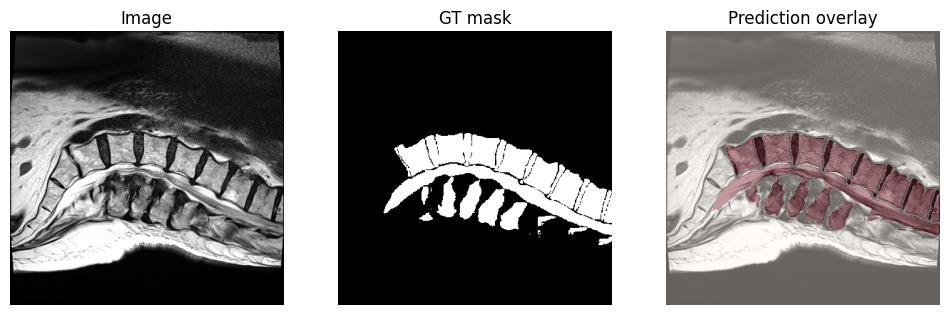

In [ ]:
model.eval()
with torch.no_grad():
    x, y = val_ds[3]
    x = x.unsqueeze(0).to(device)
    out = model(x)
    pred = torch.argmax(out, dim=1)[0].cpu()

img = x.cpu()[0, 0]
gt = y
pd = pred

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("GT mask")
plt.imshow(gt, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Prediction overlay")
plt.imshow(img, cmap="gray")
plt.imshow(pd, alpha=0.4, cmap="Reds")
plt.axis("off")

plt.show()

In [7]:
torch.save(model.state_dict(), "disc_localization_unet.pth")

Intervertebral discs were automatically localized on mid-sagittal T2-weighted MRI. Individual discs were extracted as ordered instances from cranial to caudal direction

In [ ]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

model = DiscUNet(n_classes=2)  # MUST match training
model.load_state_dict(torch.load("disc_localization_unet.pth", map_location=device))
model.to(device)
model.eval()


def pad_to_square(arr, pad_value=0):
    h, w = arr.shape
    size = max(h, w)

    pad_h = size - h
    pad_w = size - w

    return np.pad(
        arr,
        ((pad_h // 2, pad_h - pad_h // 2), (pad_w // 2, pad_w - pad_w // 2)),
        mode="constant",
        constant_values=pad_value,
    )


def resize_roi(arr, size=128):
    t = torch.from_numpy(arr).unsqueeze(0).unsqueeze(0).float()
    t = F.interpolate(t, size=(size, size), mode="bilinear", align_corners=False)
    return t.squeeze().numpy()


model.eval()

all_cases = []  # list of dicts: one entry per case

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(val_loader):
        x = x.to(device)  # (B, 1, 384, 384)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)  # (B, 384, 384)

        for i in range(preds.size(0)):
            img = x[i, 0].cpu().numpy()
            pred = preds[i].cpu().numpy()

            labeled, nlab = ndi.label(pred == 1)
            slices_all = ndi.find_objects(labeled)

            candidates = []

            for lbl, slc in enumerate(slices_all, start=1):
                if slc is None:
                    continue

                h = slc[0].stop - slc[0].start
                w = slc[1].stop - slc[1].start
                area = (labeled == lbl).sum()

                if area < 50:  # remove tiny noise
                    continue
                if h < 8 or w < 8:  # remove degenerate blobs
                    continue

                cy = (slc[0].start + slc[0].stop) / 2

                candidates.append({"slice": slc, "cy": cy, "area": area})

            candidates = sorted(candidates, key=lambda c: c["cy"])

            if len(candidates) == 0:
                # pathological fallback: empty case
                continue

            N_DISCS = 10

            if len(candidates) >= N_DISCS:
                idxs = np.linspace(0, len(candidates) - 1, N_DISCS).round().astype(int)
                selected = [candidates[j] for j in idxs]
            else:
                # fewer than N_DISCS → duplicate nearest by position
                selected = candidates.copy()
                while len(selected) < N_DISCS:
                    selected.append(selected[-1])

            rois = []

            for disc_idx, c in enumerate(selected):
                slc = c["slice"]
                roi = img[slc]

                roi = pad_to_square(roi)
                roi = resize_roi(roi, size=128)

                rois.append(roi)

            all_cases.append(
                {
                    "case_idx": batch_idx * val_loader.batch_size + i,
                    "file_name": val_loader.dataset.files[
                        batch_idx * val_loader.batch_size + i
                    ],
                    "rois": np.stack(rois),  # shape (5, 128, 128)
                }
            )

print("Total cases processed:", len(all_cases))
print("ROI shape per case:", all_cases[0]["rois"].shape)

/Users/muradyan.e/wut/aidproject/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Total cases processed: 49
ROI shape per case: (10, 128, 128)


In [ ]:
out_root = "results"
roi_dir = os.path.join(out_root, "rois")
os.makedirs(roi_dir, exist_ok=True)

rows = []

for c in all_cases:
    fname = c["file_name"]
    rois = c["rois"]  # (5, 128, 128)

    np.savez(os.path.join(roi_dir, f"{fname}.npz"), rois=rois)

    for d in range(5):
        rows.append({"file_name": fname, "disc_idx": d, "roi_file": f"{fname}.npz"})

df = pd.DataFrame(rows)
df.to_csv(os.path.join(out_root, "metadata.csv"), index=False)

print("Saved ROIs and metadata")

Saved ROIs and metadata


In [ ]:
overlay_dir = os.path.join(out_root, "overlays")
os.makedirs(overlay_dir, exist_ok=True)

model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(val_loader):
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)

        for i in range(preds.size(0)):
            case_idx = batch_idx * val_loader.batch_size + i
            case = all_cases[case_idx]

            img = x[i, 0].cpu().numpy()
            pred = preds[i].cpu().numpy()

            # recompute connected components
            labeled, _ = ndi.label(pred == 1)
            slices_all = ndi.find_objects(labeled)

            # collect candidates again
            candidates = []
            for lbl, slc in enumerate(slices_all, start=1):
                if slc is None:
                    continue
                cy = (slc[0].start + slc[0].stop) / 2
                area = (labeled == lbl).sum()
                candidates.append((cy, area, slc))

            if len(candidates) == 0:
                continue

            candidates = sorted(candidates, key=lambda x: x[0])

            # select same 5 as extraction
            if len(candidates) >= 10:
                idxs = np.linspace(0, len(candidates) - 1, 10).round().astype(int)
                selected = [candidates[j] for j in idxs]
            else:
                selected = candidates.copy()
                while len(selected) < 10:
                    selected.append(selected[-1])

            # draw
            fig, ax = plt.subplots(1, figsize=(6, 6))
            ax.imshow(img, cmap="gray")

            for d, (_, _, slc) in enumerate(selected):
                y0, y1 = slc[0].start, slc[0].stop
                x0, x1 = slc[1].start, slc[1].stop

                rect = patches.Rectangle(
                    (x0, y0),
                    x1 - x0,
                    y1 - y0,
                    linewidth=2,
                    edgecolor="red",
                    facecolor="none",
                )
                ax.add_patch(rect)
                ax.text(x0, y0 - 5, f"D{d}", color="red", fontsize=10)

            ax.set_title(case["file_name"])
            ax.axis("off")

            plt.savefig(
                os.path.join(overlay_dir, f"{case['file_name']}_boxes.png"),
                bbox_inches="tight",
                dpi=150,
            )
            plt.close()

/Users/muradyan.e/wut/aidproject/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
